# Request Log Analysis

## Functionalities
- Display a summary of requests and their performance metrics.

## Input
Log files are read from a directory in `../data`. This directory is assumed to have the following structure:
```
logs/
  [node-1]/
    loadgen[0-9]*.tar.gz
  ...
  [node-n]/
    loadgen[0-9]*.tar.gz
```

## Notebook Configuration

In [8]:
########## GENERAL
# Name of the directory in `../data`
EXPERIMENT_DIRNAME = "BuzzBlogBenchmark_2022-04-14-05-26-13"
# Ramp up duration (in sec)
RAMP_UP_DURATION = 180
# Ramp down duration (in sec)
RAMP_DOWN_DURATION = 60

########## LATENCY
# Bin size
LATENCY_BIN_IN_MS = 25

## Notebook Setup

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath(os.path.join("..")))
from utils.utils import *

experiment_dirpath = os.path.join(os.path.abspath(""), "..", "data", EXPERIMENT_DIRNAME)

## Log Parsing & Processing

In [10]:
# Build data frame
requests = pd.concat([df[2] for df in get_loadgen_df(experiment_dirpath)])

In [11]:
# Extract experiment information
start_time = get_experiment_start_time(experiment_dirpath)
max_latency_in_s = int(requests["latency"].max()) + 1.0
n_request_types = len(requests.type.unique())

In [12]:
# (Re) Build columns
requests["timestamp"] = requests.apply(lambda r: (r["timestamp"] - start_time).total_seconds(), axis=1)
requests["window_1000"] = requests["timestamp"].round(0).multiply(1000)
requests["window_10"] = requests["timestamp"].round(2).multiply(1000)

In [13]:
# (Re) Create index
requests.set_index("timestamp", inplace=True)
requests.sort_index(inplace=True)

## Status of Requests

<AxesSubplot:title={'center':'Number of successful/failed requests'}>

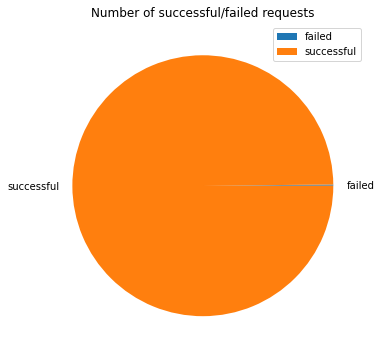

In [14]:
# Data frame
df = requests[(requests.index >= RAMP_UP_DURATION) & (requests.index <= requests.index.max() - RAMP_DOWN_DURATION)].groupby(["status"]).count()["method"]
# Plot
fig = plt.figure(figsize=(18, 6))
ax = fig.gca()
df.plot(ax=ax, kind="pie", title="Number of successful/failed requests", xlabel="", ylabel="", legend=True)

<AxesSubplot:title={'center':'HTTP status code of failed requests'}>

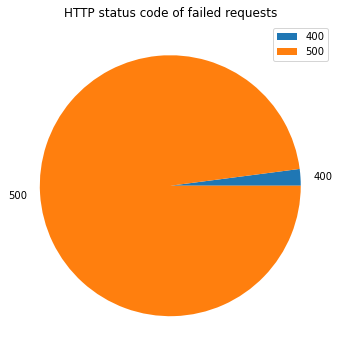

In [15]:
# Data frame
df = requests[(requests["status"] == "failed") & (requests.index >= RAMP_UP_DURATION) & (requests.index <= requests.index.max() - RAMP_DOWN_DURATION)].groupby(["status_code"]).count()["method"]
# Plot
fig = plt.figure(figsize=(18, 6))
ax = fig.gca()
df.plot(ax=ax, kind="pie", title="HTTP status code of failed requests", xlabel="", ylabel="", legend=True)

## Type of Requests

<AxesSubplot:title={'center':'Number of read/write requests'}>

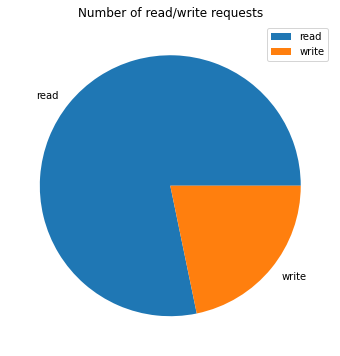

In [16]:
# Data frame
df = requests[(requests.index >= RAMP_UP_DURATION) & (requests.index <= requests.index.max() - RAMP_DOWN_DURATION)].groupby(["rw"]).count()["method"]
# Plot
fig = plt.figure(figsize=(18, 6))
ax = fig.gca()
df.plot(ax=ax, kind="pie", title="Number of read/write requests", xlabel="", ylabel="", legend=True)

<AxesSubplot:title={'center':'Number of requests of each type'}, ylabel='Requests (count)'>

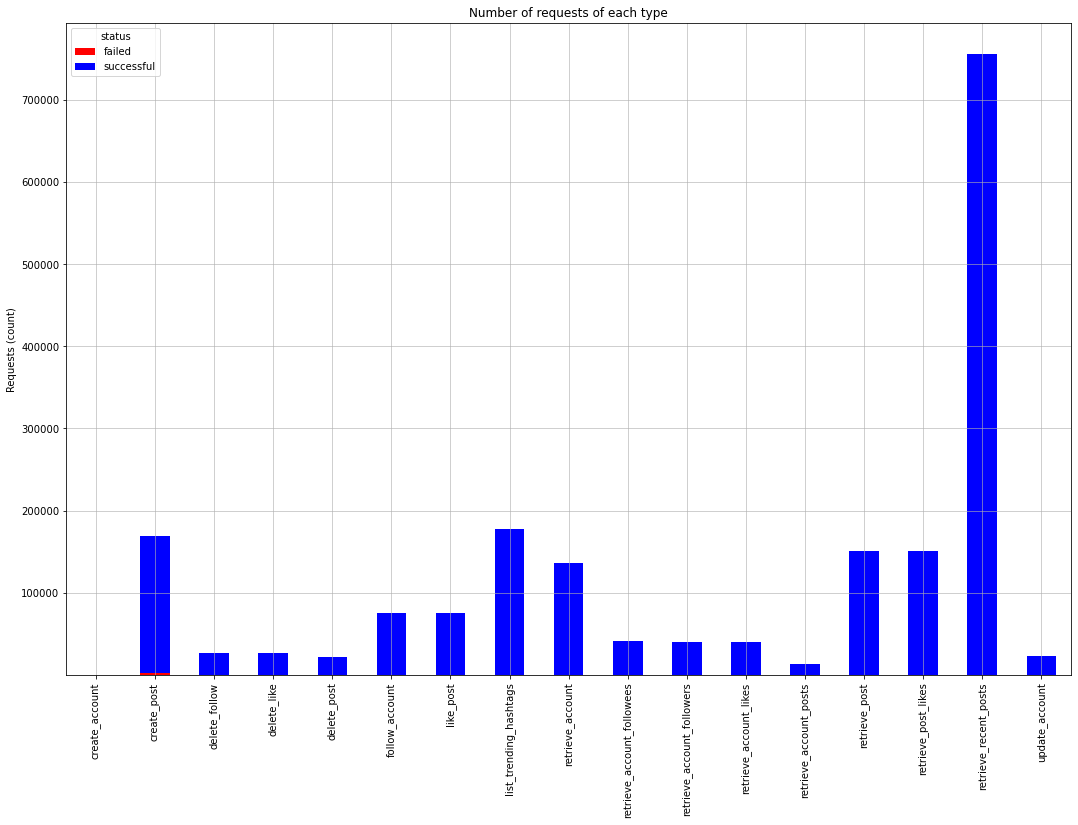

In [17]:
# Data frame
df = requests[(requests.index >= RAMP_UP_DURATION) & (requests.index <= requests.index.max() - RAMP_DOWN_DURATION)].groupby(["type", "status"]).count()["method"].unstack().fillna(0)
# Plot
fig = plt.figure(figsize=(18, 12))
ax = fig.gca()
ax.grid(alpha=0.75)
df.plot(ax=ax, kind="bar", stacked=True, title="Number of requests of each type", xlabel="", ylabel="Requests (count)", color={"failed": "red", "successful": "blue"}, legend=True, grid=True)

## Request Latency Distribution

<AxesSubplot:title={'center':'Latency Distribution of Successful Requests Excluding Ramping Periods'}, xlabel='Latency (millisec)', ylabel='Frequency'>

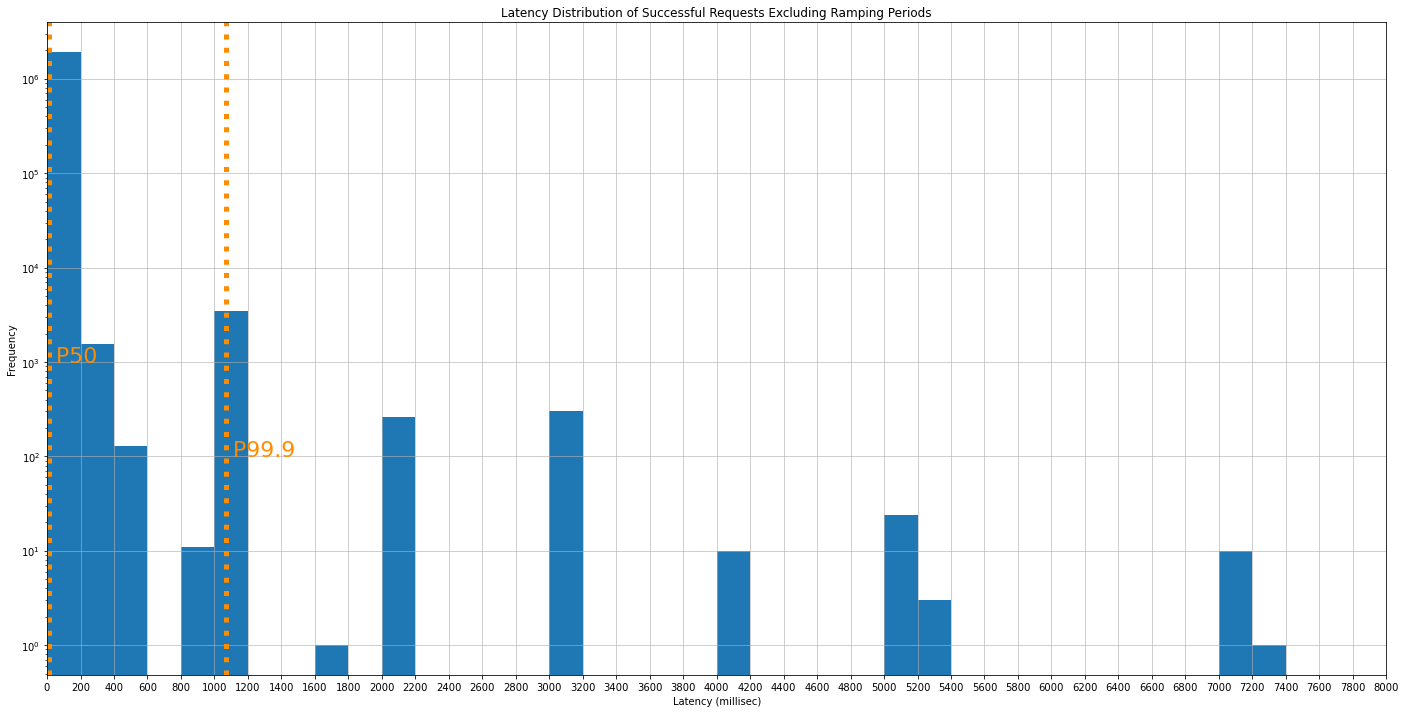

In [18]:
LATENCY_BIN_IN_MS = 200
# Data frame
df = requests[(requests["status"] == "successful") & (requests.index >= RAMP_UP_DURATION) & (requests.index <= requests.index.max() - RAMP_DOWN_DURATION)]
df["latency_bin"] = df.apply(lambda r: int(r["latency"] * 1000 // LATENCY_BIN_IN_MS), axis=1)
p999 = df["latency"].quantile(0.999) * 1000
p50 = df["latency"].quantile(0.50) * 1000
# Plot
fig = plt.figure(figsize=(24, 12))
ax = fig.gca(xlabel="Latency (millisec)", ylabel="Requests (count)")
ax.grid(alpha=0.75)
ax.set_yscale("log")
ax.set_xlim((0, (1000 // LATENCY_BIN_IN_MS) * max_latency_in_s))
ax.set_xticks(range(int((1000 // LATENCY_BIN_IN_MS) * max_latency_in_s) + 1))
ax.set_xticklabels(range(0, (int((1000 // LATENCY_BIN_IN_MS) * max_latency_in_s) + 1) * LATENCY_BIN_IN_MS, LATENCY_BIN_IN_MS))
ax.axvline(x=p50 / LATENCY_BIN_IN_MS, ls="dotted", lw=5, color="darkorange")
ax.text(x=p50 / LATENCY_BIN_IN_MS, y=1000, s=" P50", fontsize=22, color="darkorange")
ax.axvline(x=p999 / LATENCY_BIN_IN_MS, ls="dotted", lw=5, color="darkorange")
ax.text(x=p999 / LATENCY_BIN_IN_MS, y=100, s=" P99.9", fontsize=22, color="darkorange")
df["latency_bin"].plot(ax=ax, kind="hist", title="Latency Distribution of Successful Requests Excluding Ramping Periods", bins=range(int((1000 // LATENCY_BIN_IN_MS) * max_latency_in_s)), grid=True)

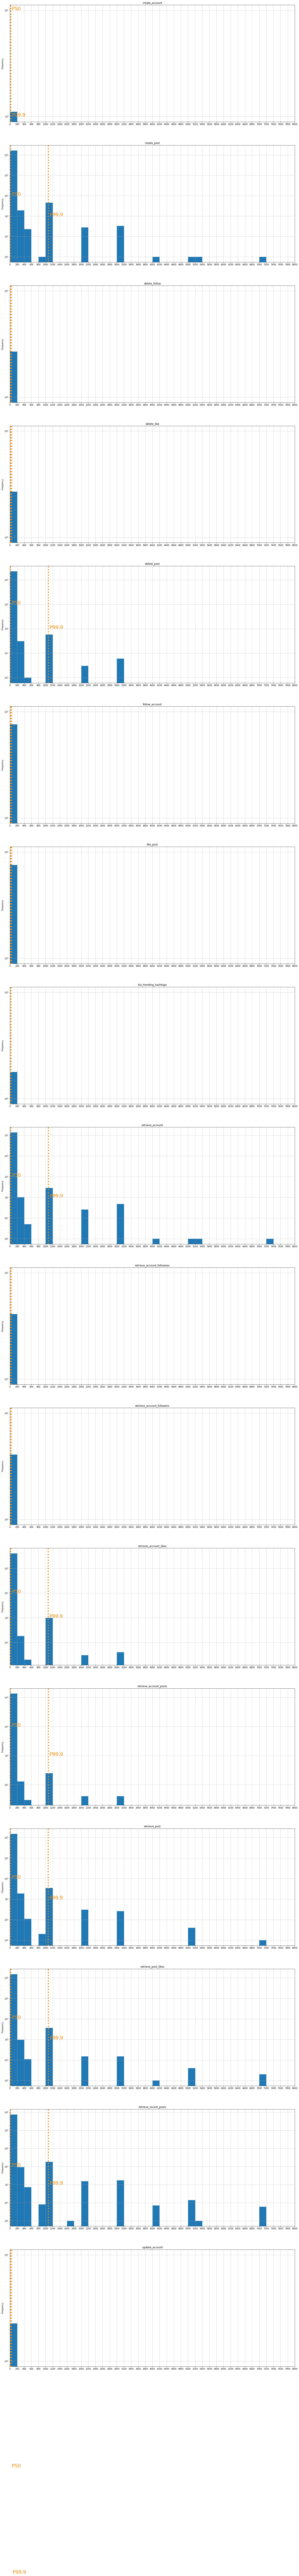

In [19]:
fig = plt.figure(figsize=(24, n_request_types * 12))
for (i, request_type) in enumerate(sorted(requests.type.unique())):
    # Data frame
    df = requests[(requests["status"] == "successful") & (requests["type"] == request_type) & (requests.index >= RAMP_UP_DURATION) & (requests.index <= requests.index.max() - RAMP_DOWN_DURATION)]
    df["latency_bin"] = df.apply(lambda r: int(r["latency"] * 1000 // LATENCY_BIN_IN_MS), axis=1)
    p999 = df["latency"].quantile(0.999) * 1000
    p50 = df["latency"].quantile(0.50) * 1000
    # Plot
    ax = fig.add_subplot(n_request_types, 1, i + 1)
    ax.grid(alpha=0.75)
    ax.set_yscale("log")
    ax.set_xlim((0, (1000 // LATENCY_BIN_IN_MS) * max_latency_in_s))
    ax.set_xticks(range(int((1000 // LATENCY_BIN_IN_MS) * max_latency_in_s) + 1))
    ax.set_xticklabels(range(0, (int((1000 // LATENCY_BIN_IN_MS) * max_latency_in_s) + 1) * LATENCY_BIN_IN_MS, LATENCY_BIN_IN_MS))
    ax.axvline(x=p50 / LATENCY_BIN_IN_MS, ls="dotted", lw=5, color="darkorange")
    ax.text(x=p50 / LATENCY_BIN_IN_MS, y=1000, s=" P50", fontsize=22, color="darkorange")
    ax.axvline(x=p999 / LATENCY_BIN_IN_MS, ls="dotted", lw=5, color="darkorange")
    ax.text(x=p999 / LATENCY_BIN_IN_MS, y=100, s=" P99.9", fontsize=22, color="darkorange")
    df["latency_bin"].plot(ax=ax, kind="hist", title=request_type, xlabel="Latency (millisec)", ylabel="Requests (count)", bins=range(int((1000 // LATENCY_BIN_IN_MS) * max_latency_in_s)), grid=True)

## Request Instantaneous Latency

<AxesSubplot:title={'center':'Latency of Successful Requests'}, xlabel='Time (millisec)', ylabel='Latency (sec)'>

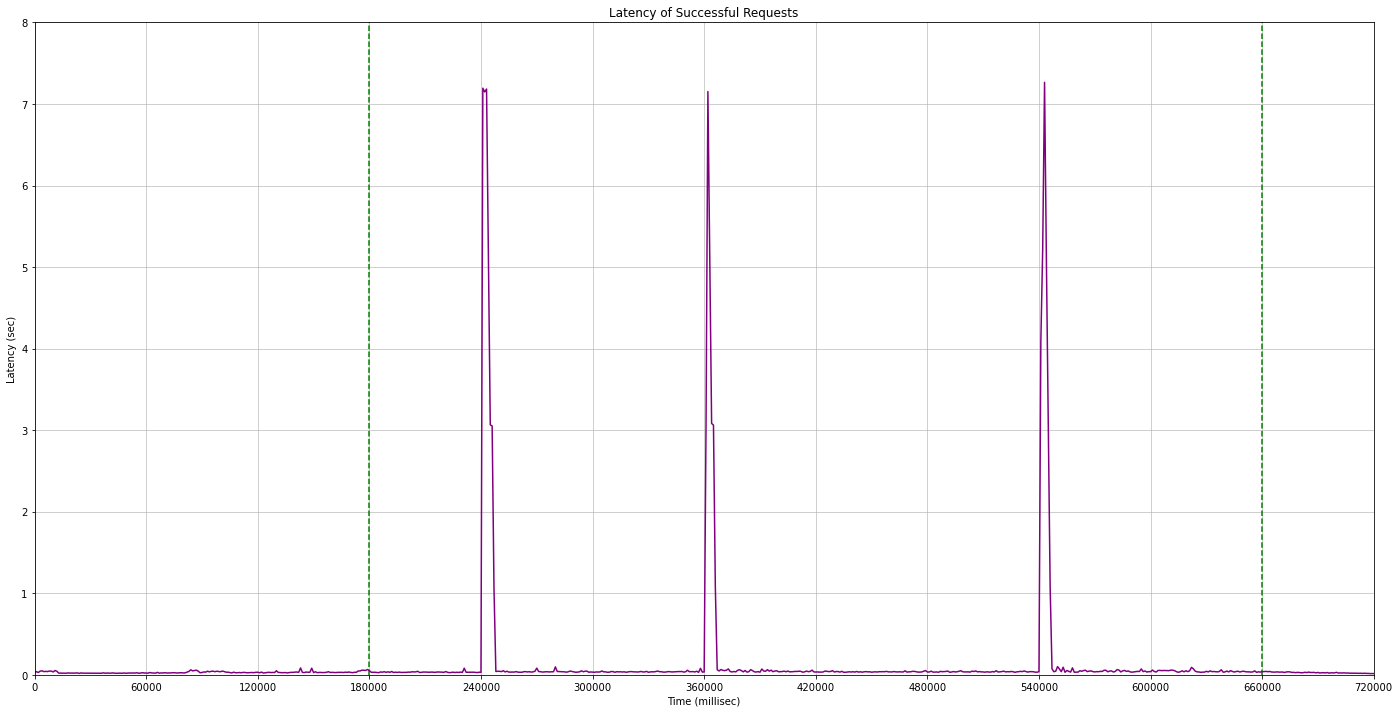

In [20]:
# Data frame
df = requests[requests["status"] == "successful"]
df = df.groupby(["window_1000"])["latency"].max().reindex(range(0, int(df["window_1000"].max()) + 1, 1000), fill_value=0)
# Plot
fig = plt.figure(figsize=(24, 12))
ax = fig.gca()
ax.grid(alpha=0.75)
ax.set_xlim((int(df.index.min()), int(df.index.max())))
ax.set_ylim((0, max_latency_in_s))
ax.axvline(x=RAMP_UP_DURATION * 1000, ls="--", color="green")
ax.axvline(x=df.index.max() - (RAMP_DOWN_DURATION * 1000), ls="--", color="green")
df.plot(ax=ax, kind="line", title="Latency of Successful Requests", xlabel="Time (millisec)", ylabel="Latency (sec)", color="purple", grid=True, xticks=range(int(df.index.min()), int(df.index.max()) + 1, 60000))

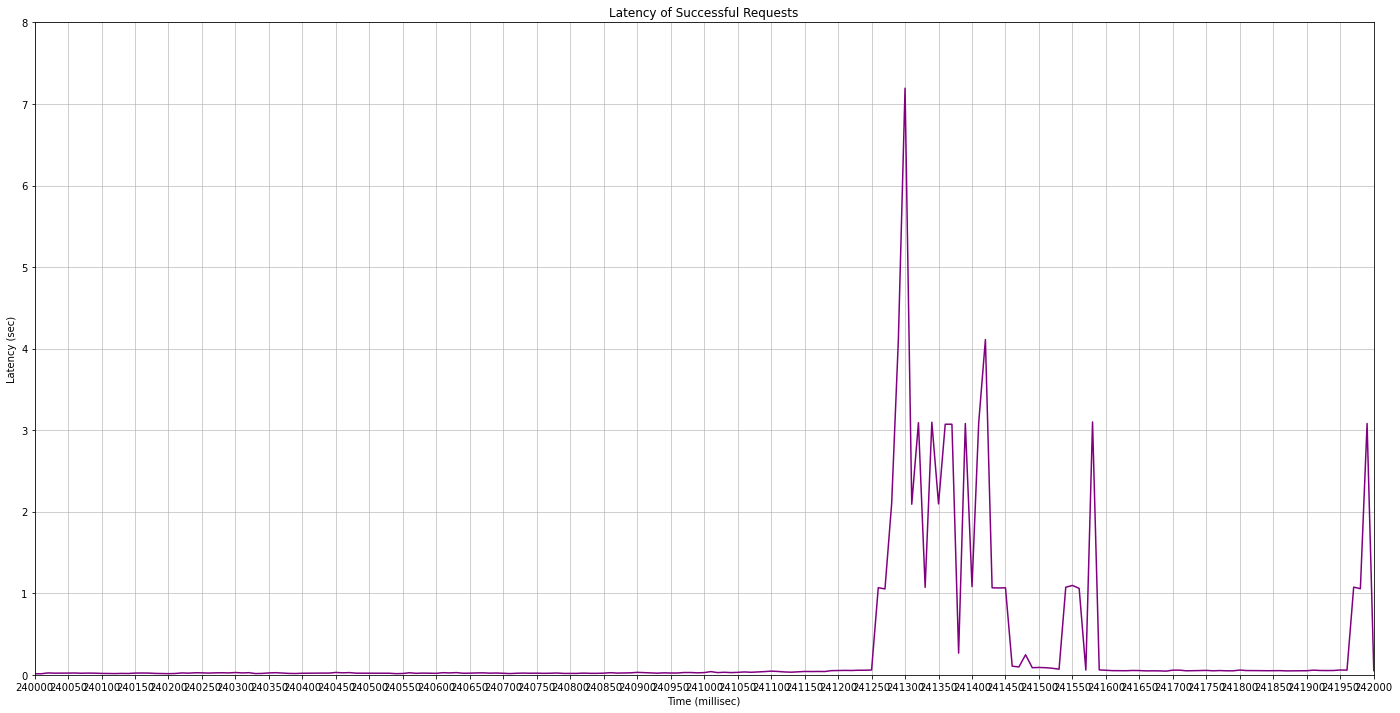

In [26]:
########## ZOOM IN
# Minimum time (in sec)
MIN_TIME = 240
# Maximum time (in sec)
MAX_TIME = 242
# Request type (None: all request types)
REQUEST_TYPE = None

if MIN_TIME and MAX_TIME:
    # Data frame
    df = requests[(requests["status"] == "successful") & (requests.index >= MIN_TIME) & (requests.index <= MAX_TIME)]
    if REQUEST_TYPE:
        df = df[(df["type"] == REQUEST_TYPE)]
    df = df.groupby(["window_10"])["latency"].max().reindex(range(int(df["window_10"].min()), int(df["window_10"].max()) + 1, 10), fill_value=0)
    # Plot
    fig = plt.figure(figsize=(24, 12))
    ax = fig.gca()
    ax.grid(alpha=0.75)
    ax.set_xlim((int(df.index.min()), int(df.index.max())))
    ax.set_ylim((0, max_latency_in_s))
    ax.axvline(x=RAMP_UP_DURATION * 1000, ls="--", color="green")
    ax.axvline(x=requests.index.values.max() - (RAMP_DOWN_DURATION * 1000), ls="--", color="green")
    df.plot(ax=ax, kind="line", title="Latency of Successful Requests", xlabel="Time (millisec)", ylabel="Latency (sec)", color="purple", grid=True, xticks=range(int(df.index.min()), int(df.index.max()) + 1, 50))

## Request Throughput

<AxesSubplot:title={'center':'Throughput (requests per second)'}, xlabel='Time (millisec)', ylabel='Requests (count)'>

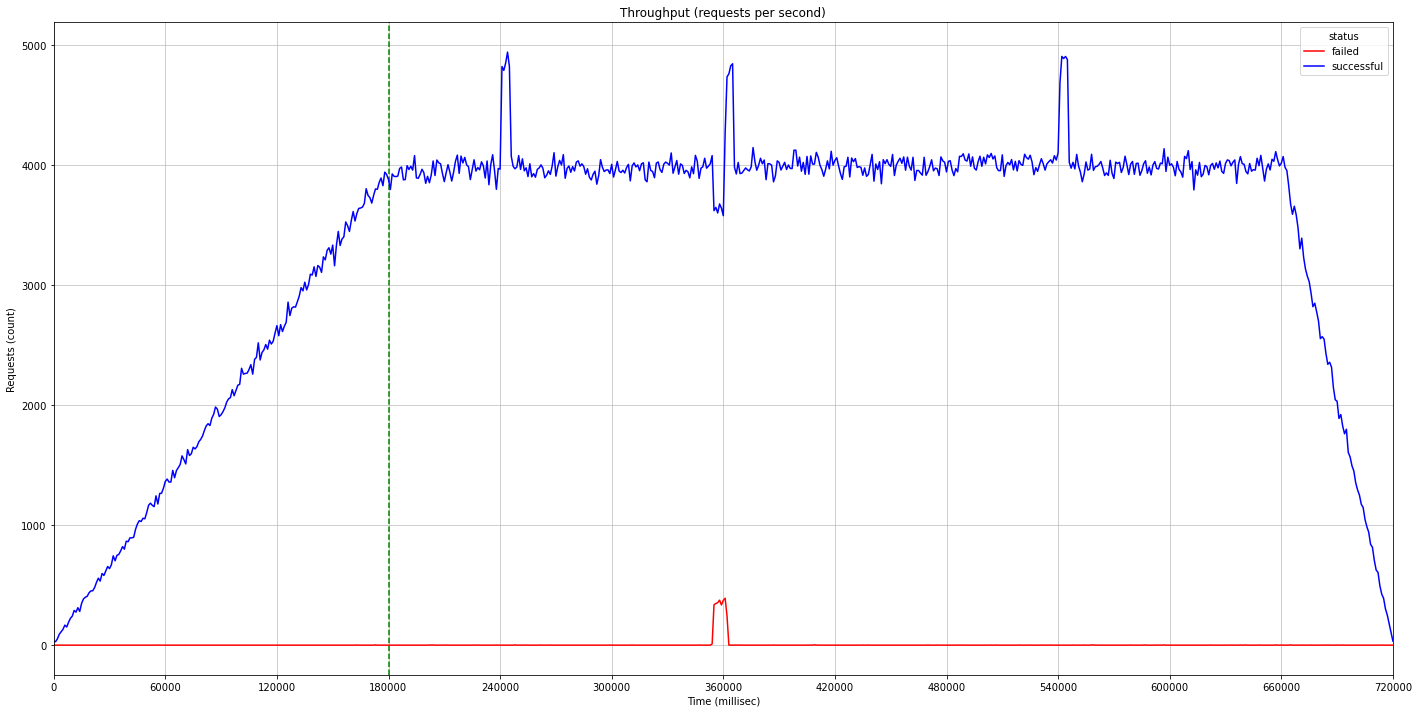

In [22]:
# Data frame
df = requests.groupby(["window_1000", "status"])["window_1000"].count().unstack().fillna(0)
df = df.reindex(range(0, int(df.index.max()) + 1, 1000), fill_value=0)
# Plot
fig = plt.figure(figsize=(24, 12))
ax = fig.gca()
ax.grid(alpha=0.75)
ax.axvline(x=RAMP_UP_DURATION * 1000, ls="--", color="green")
ax.axvline(x=requests.index.values.max() - (RAMP_DOWN_DURATION * 1000), ls="--", color="green")
ax.set_xlim((int(df.index.min()), int(df.index.max())))
df.plot(ax=ax, kind="line", title="Throughput (requests per second)", xlabel="Time (millisec)", ylabel="Requests (count)", color={"failed": "red", "successful": "blue"}, legend=True, grid=True, xticks=range(int(df.index.min()), int(df.index.max()) + 1, 60000))

## Summary

In [23]:
df = requests[(requests.index >= RAMP_UP_DURATION) & (requests.index <= requests.index.max() - RAMP_DOWN_DURATION)]
print("Number of requests (Excluding Ramping Up and Down Periods)")
print("  Total:       %7d" % df.shape[0])
print("  Status")
print("    Failed:    %7d (%9.5f%%)" % (df[df["status"] == "failed"]["status"].count(),
    (df[df["status"] == "failed"]["status"].count() / df.shape[0]) * 100))
print("    Succesful: %7d (%9.5f%%)" % (df[df["status"] == "successful"]["status"].count(),
    (df[df["status"] == "successful"]["status"].count() / df.shape[0]) * 100))
print("  Type")
print("    Read:      %7d (%9.5f%%)" % (df[df["rw"] == "read"]["rw"].count(),
    (df[df["rw"] == "read"]["rw"].count() / df.shape[0]) * 100))
print("    Write:     %7d (%9.5f%%)" % (df[df["rw"] == "write"]["rw"].count(),
    (df[df["rw"] == "write"]["rw"].count() / df.shape[0]) * 100))
print("Experiment duration (s)")
print("  Total:       %7.3f" % (df.index.values.max() - df.index.values.min()))
print("Latency (ms)")
print("P99.9:         %7.2f" % (df[df["status"] == "successful"]["latency"].quantile(0.999) * 1000))
print("  P99:         %7.2f" % (df[df["status"] == "successful"]["latency"].quantile(0.99) * 1000))
print("  P95:         %7.2f" % (df[df["status"] == "successful"]["latency"].quantile(0.95) * 1000))
print("  P50:         %7.2f" % (df[df["status"] == "successful"]["latency"].quantile(0.50) * 1000))
print("  Avg:         %7.2f" % (df[df["status"] == "successful"]["latency"].mean() * 1000))
print("  Std:         %7.2f" % (df[df["status"] == "successful"]["latency"].std() * 1000))
print("Throughput (req/s)")
print("  P99:         %7.2f" % df.groupby(["window_1000"])["window_1000"].count().reindex(range(int(df["window_1000"].min()), int(df["window_1000"].max()) + 1, 1000), fill_value=0).quantile(0.99))
print("  P95:         %7.2f" % df.groupby(["window_1000"])["window_1000"].count().reindex(range(int(df["window_1000"].min()), int(df["window_1000"].max()) + 1, 1000), fill_value=0).quantile(0.95))
print("  P50:         %7.2f" % df.groupby(["window_1000"])["window_1000"].count().reindex(range(int(df["window_1000"].min()), int(df["window_1000"].max()) + 1, 1000), fill_value=0).quantile(0.50))
print("  Avg:         %7.2f" % df.groupby(["window_1000"])["window_1000"].count().reindex(range(int(df["window_1000"].min()), int(df["window_1000"].max()) + 1, 1000), fill_value=0).mean())
print("  Std:         %7.2f" % df.groupby(["window_1000"])["window_1000"].count().reindex(range(int(df["window_1000"].min()), int(df["window_1000"].max()) + 1, 1000), fill_value=0).std())

Number of requests (Excluding Ramping Up and Down Periods)
  Total:       1927624
  Status
    Failed:       2821 (  0.14635%)
    Succesful: 1924803 ( 99.85365%)
  Type
    Read:      1508404 ( 78.25198%)
    Write:      419220 ( 21.74802%)
Experiment duration (s)
  Total:       480.481
Latency (ms)
P99.9:         1067.00
  P99:           51.00
  P95:           26.00
  P50:           14.00
  Avg:           18.28
  Std:           69.83
Throughput (req/s)
  P99:         4880.80
  P95:         4102.00
  P50:         3990.00
  Avg:         4007.53
  Std:          186.14
